In [407]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from scipy.optimize import minimize
import requests
from io import StringIO
import seaborn as sns

##Function definition

$\mu_p = \mathbb{E}[R_p] = \mathbf{w}^\top \boldsymbol{\mu}$

$\mu_p = \sum_{i=1}^{N} w_i \mu_i$

$\sigma_p^2 = \mathrm{Var}(R_p) = \mathbf{w}^\top \boldsymbol{\Sigma}\, \mathbf{w}$

$\sigma_p^2 = \sum_{i=1}^{N} \sum_{j=1}^{N} w_i w_j \sigma_{ij}$




In [408]:
def getdata(tickers,start,end):
    data=yf.download(tickers,start,end,auto_adjust=True)
    data=data['Close']
    return data

def moments(prices):
    returns=prices.pct_change().dropna()
    mu=returns.mean()*250
    cov=returns.cov()*250
    return returns,mu,cov

def ptf_stats(weights,mu,cov,rf):
    ptf_ret=np.dot(weights.T,mu)
    ptf_var=np.dot(weights.T,np.dot(cov,weights))
    ptf_std=np.sqrt(ptf_var)
    sharpe=(ptf_ret-rf)/ptf_std
    return ptf_ret,ptf_var,sharpe

def objfunc(weights,cov):#variance of the portfolio
    return np.dot(weights.T,np.dot(cov,weights))
def optimalportfolio(cov,mu=None,flag=1,shortselling=False):#flag=1 minimum variance portfolio only cov required, flag=2 max variance portoflio both cov and mu required
    N=cov.shape[0]
    if flag==1:
        a=np.ones(shape=(N,1))
    elif flag==2:
      a=mu
    if shortselling==False:
      bounds=tuple((0,1) for stock in range(N))
    if shortselling==True:
      bounds=None
    ewp=np.ones(N)/N
    constraints=({'type':'eq','fun':lambda w: np.dot(w.T,a)-1})
    result=minimize(objfunc,ewp,args=(cov,),method='SLSQP',bounds=bounds,constraints=constraints, options={'maxiter': 10000})
    if result.success==True:
      wstar=result.x
    else:
      print(result.message)
      wstar=None
    return wstar/wstar.sum()

def cov_corr(cov):
 stds=np.sqrt(np.diag(cov))
 corr=cov/np.outer(stds,stds)
 return corr

def corr2cov(corr, stds):
  return corr*np.outer(stds,stds)

def shrinkage(prices):
  returns,mu, cov = moments(prices)
  cov /= 250
  vars = np.diag(cov)
  stds = np.sqrt(vars)

  corr = cov_corr(cov)
  N = np.size(mu)
  rhobar = (np.sum(np.sum(corr))-N)/(N*(N-1))

  equal_corr_matrix = rhobar*np.ones(shape=(N,N))

  for i in range(int(N)):
    equal_corr_matrix[i,i] = 1

  F_rhobar = corr2cov(equal_corr_matrix, stds)

  delta = 0.5

  shrunk_cov = delta*F_rhobar +(1-delta)*cov

  return shrunk_cov*250


##variable set up and optimization

In [409]:
start=datetime(2018,1,1)
end=datetime(2021,12,31)
tickers=['AMZN', 'GOOGL', 'NFLX', 'JPM', 'BAC']

In [410]:
prices=getdata(tickers,start,end)
prices=prices.loc[:,tickers]
prices.head()

[*********************100%***********************]  5 of 5 completed


Ticker,AMZN,GOOGL,NFLX,JPM,BAC
Date,,,,,
2018-01-02,59.450500,53.258095,20.107000,86.340874,24.776773
2018-01-03,60.209999,54.166737,20.504999,86.428864,24.693911
2018-01-04,60.479500,54.377136,20.563000,87.667007,25.017092
2018-01-05,61.457001,55.098190,20.999001,87.104240,25.133099
2018-01-08,62.343498,55.292725,21.205000,87.232864,24.959085


Risk free

In [411]:
rf_series=getdata('^IRX',start,end)

[*********************100%***********************]  1 of 1 completed


In [412]:
rf_series['^IRX']=rf_series['^IRX']/100

In [413]:
rf_series
rf=rf_series['^IRX'].mean()

In [414]:
prices

Ticker,AMZN,GOOGL,NFLX,JPM,BAC
Date,,,,,
2018-01-02,59.450500,53.258095,20.107000,86.340874,24.776773
2018-01-03,60.209999,54.166737,20.504999,86.428864,24.693911
2018-01-04,60.479500,54.377136,20.563000,87.667007,25.017092
2018-01-05,61.457001,55.098190,20.999001,87.104240,25.133099
2018-01-08,62.343498,55.292725,21.205000,87.232864,24.959085
...,...,...,...,...,...
2021-12-23,171.068497,145.814758,61.409000,140.949982,40.124428
2021-12-27,169.669495,146.797333,61.312000,141.756683,40.323166
2021-12-28,170.660995,145.586990,61.070999,142.186859,40.377361


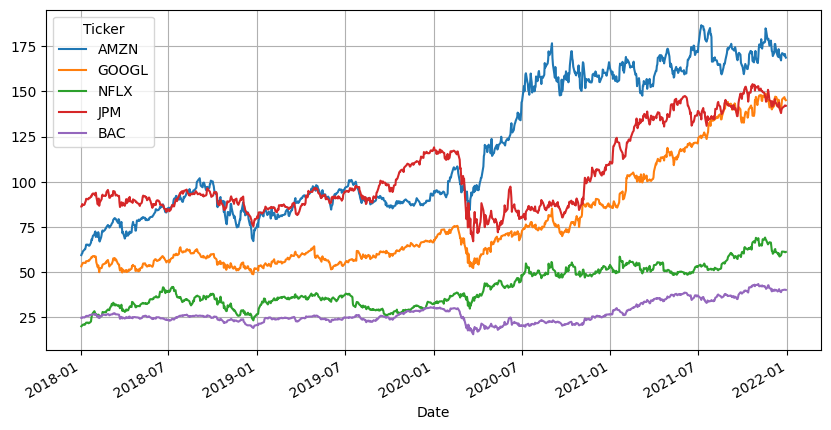

In [415]:
prices.plot(figsize=(10,5))
plt.grid()
plt.show()

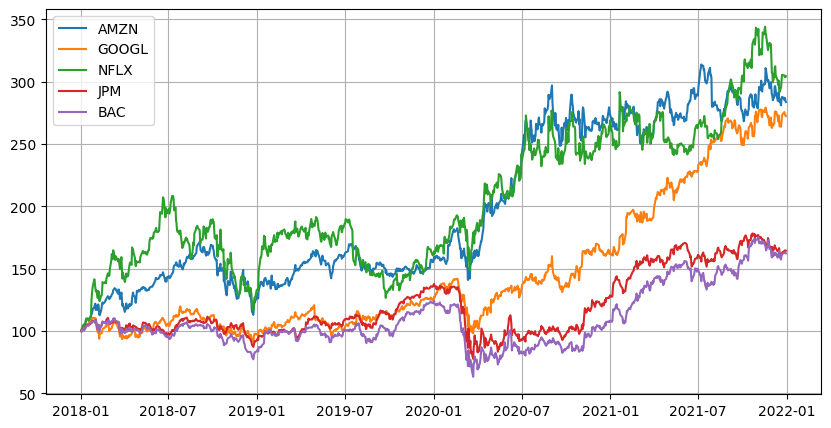

In [416]:
plt.figure(figsize=(10,5))
plt.plot(prices/prices.iloc[0]*100)
plt.legend(prices.columns)
plt.grid()
plt.show()

In [417]:
returns,mu,cov=moments(prices)

In [418]:
returns.head()

Ticker,AMZN,GOOGL,NFLX,JPM,BAC
Date,,,,,
2018-01-03,0.012775,0.017061,0.019794,0.001019,-0.003344
2018-01-04,0.004476,0.003884,0.002829,0.014326,0.013087
2018-01-05,0.016163,0.013260,0.021203,-0.006419,0.004637
2018-01-08,0.014425,0.003531,0.009810,0.001477,-0.006924
2018-01-09,0.004676,-0.001274,-0.012921,0.005069,0.004980


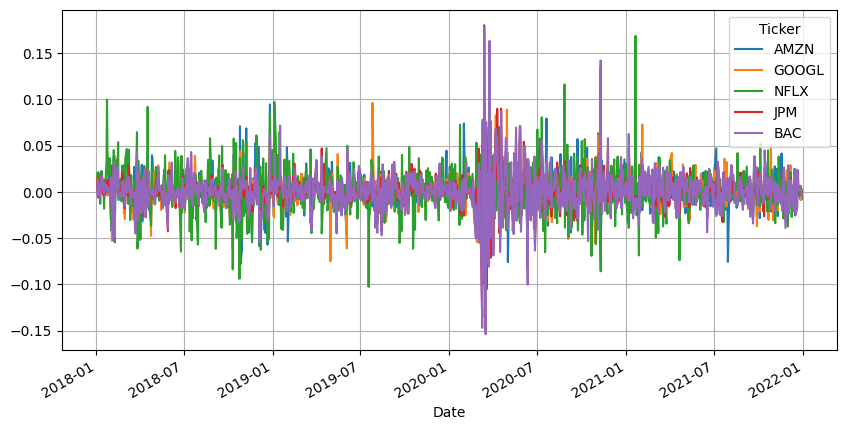

In [419]:
returns.plot(figsize=(10,5))
plt.grid()
plt.show()

In [420]:
vars=np.diag(cov)
stds=np.sqrt(vars)

/tmp/ipython-input-1686505531.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(txt,(stds[i],mu[i]))


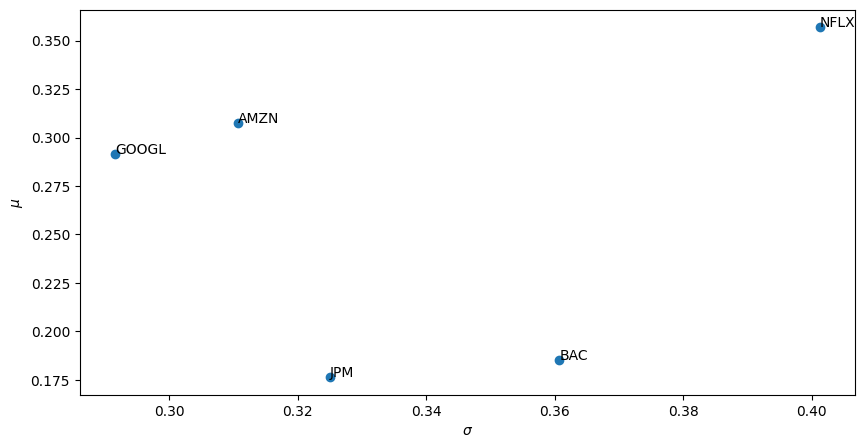

In [421]:
fig,ax=plt.subplots(figsize=(10,5))
ax.scatter(stds,mu)
for i,txt in enumerate(tickers):
    ax.annotate(txt,(stds[i],mu[i]))

plt.xlabel(r"$\sigma$", fontsize=10)
plt.ylabel(r"$\mu$", fontsize=10)

plt.show()

In [422]:
np.random.seed(100)
N=len(tickers)
weights=np.random.random(N)
weights=weights/weights.sum()
weights

array([0.25928444, 0.13282332, 0.20255761, 0.40308303, 0.00225159])

In [423]:
print(ptf_stats(weights,mu,cov,rf))

(np.float64(0.26227229864476664), np.float64(0.06325836498117493), np.float64(0.9997233927795237))


In [424]:
prices_traninig=prices['2018-1-1':'2021-6-30']
prices_testing=prices['2021-7-1':]
rf_series_traninig=rf_series['2018-1-1':'2021-6-30']
rf_series_testing=rf_series['2021-7-1':]

In [425]:
returns_traninig,mu_traninig,cov_traninig=moments(prices_traninig)
returns_testing,mu_testing,cov_testing=moments(prices_testing)
rf_traninig=rf_series_traninig['^IRX'].mean()
rf_testing=rf_series_testing['^IRX'].mean()

In [426]:
w_naive=np.ones(shape=len(tickers))/len(tickers)
w_minvar_training=optimalportfolio(cov_traninig,flag=1,shortselling=True)
w_maxsharpe_training=optimalportfolio(cov_traninig,mu_traninig,2,True)

In [427]:
portoflio_weights_training=pd.DataFrame([w_naive,w_minvar_training,w_maxsharpe_training],
                               columns=tickers,
                               index=['Naive','Minvar','Maxsharpe'])
portoflio_weights_training

,AMZN,GOOGL,NFLX,JPM,BAC
Naive,0.200000,0.200000,0.200000,0.200000,0.200000
Minvar,0.350527,0.249151,0.041692,0.632131,-0.273501
Maxsharpe,0.597085,0.161268,0.105561,0.519875,-0.383788


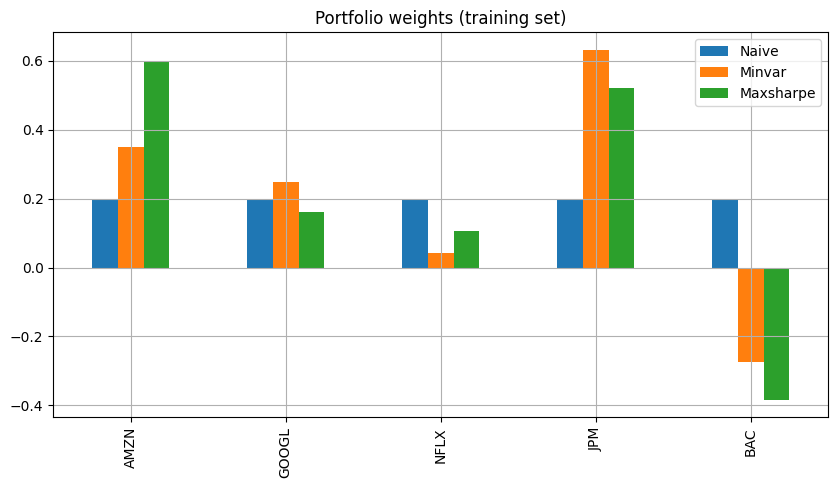

In [428]:
portoflio_weights_training.T.plot(kind='bar',figsize=(10,5))
plt.legend(portoflio_weights_training.index)
plt.title('Portfolio weights (training set)')
plt.grid()

In [429]:
w_naive_stats_training=ptf_stats(w_naive,mu_traninig,cov_traninig,rf_traninig)
w_minvar_stats_training=ptf_stats(w_minvar_training,mu_traninig,cov_traninig,rf_traninig)
w_maxsharpe_stats_training=ptf_stats(w_maxsharpe_training,mu_traninig,cov_traninig,rf_traninig)

stats_training=pd.DataFrame([w_naive_stats_training,w_minvar_stats_training,w_maxsharpe_stats_training],
                            columns=['Exp ret','Var','SR'],
                            index=['Naive','Minvar','Maxsharpe'])
stats_training

,Exp ret,Var,SR
Naive,0.273515,0.071767,0.974950
Minvar,0.278619,0.065398,1.041285
Maxsharpe,0.322762,0.075735,1.128014


<Axes: >

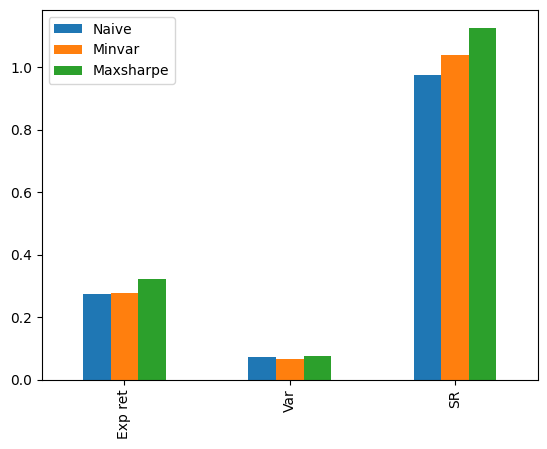

In [430]:
stats_training.T.plot(kind='bar')

In [431]:
w_naive_stats_test=ptf_stats(w_naive,mu_testing,cov_testing,rf_testing)
w_minvar_stats_test=ptf_stats(w_minvar_training,mu_testing,cov_testing,rf_testing)
w_maxsharpe_stats_test=ptf_stats(w_maxsharpe_training,mu_testing,cov_testing,rf_testing)

stats_test=pd.DataFrame([w_naive_stats_test,w_minvar_stats_test,w_maxsharpe_stats_test],
                            columns=['Exp ret','Var','SR'],
                            index=['Naive','Minvar','Maxsharpe'])
stats_test.T

,Naive,Minvar,Maxsharpe
Exp ret,0.184852,0.092364,0.049854
Var,0.022672,0.025074,0.034799
SR,1.224871,0.580645,0.265001


<Axes: >

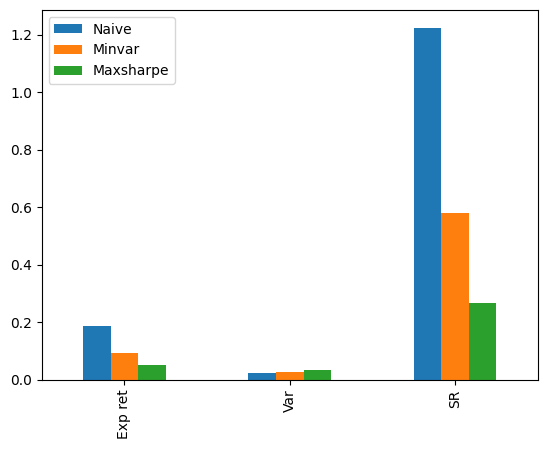

In [432]:
stats_test.T.plot(kind='bar')

##Scrap tickers from wikipedia

In [433]:
url="https://en.wikipedia.org/wiki/S%26P_100"
headers={"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
response=requests.get(url, headers=headers)
websiteTables=pd.read_html(StringIO(response.text))
thirdTable=websiteTables[2]
all_tickers=thirdTable['Symbol'].values.tolist()


In [434]:
from logging import exception
valid=[]
invalid=[]
for ticker in all_tickers:
  try:
    t=yf.Ticker(ticker)
    hist=t.history(period='1d')
    if hist.empty==False:
      valid.append(ticker)
    else:
      invalid.append(ticker)
  except Exception:
    invalid.append(ticker)


ERROR:yfinance:$BRK.B: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


In [435]:
all_prices=getdata(valid,start,end)

[*********************100%***********************]  100 of 100 completed


In [436]:
all_prices_traninig=all_prices['2018-1-1':'2021-6-30']
all_prices_testing=all_prices['2021-7-1':]

In [437]:
all_returns,all_mu,all_cov=moments(all_prices)
all_returns_training,all_mu_training,all_cov_training=moments(all_prices_traninig)
all_returns_training,all_mu_training,all_cov_training=moments(all_prices_traninig)
all_returns_testing,all_mu_testing,all_cov_testing=moments(all_prices_testing)

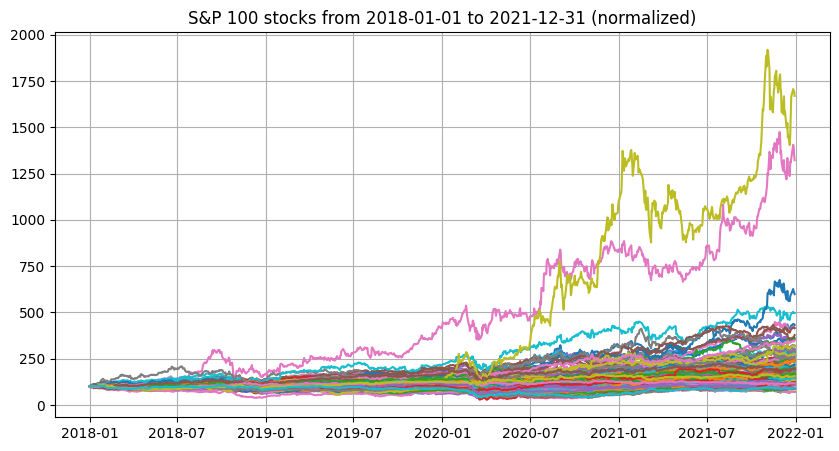

In [438]:
plt.figure(figsize=(10,5))
plt.plot(all_prices/all_prices.iloc[0]*100)
plt.grid()
plt.title(f'S&P 100 stocks from {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')} (normalized)')
plt.show()

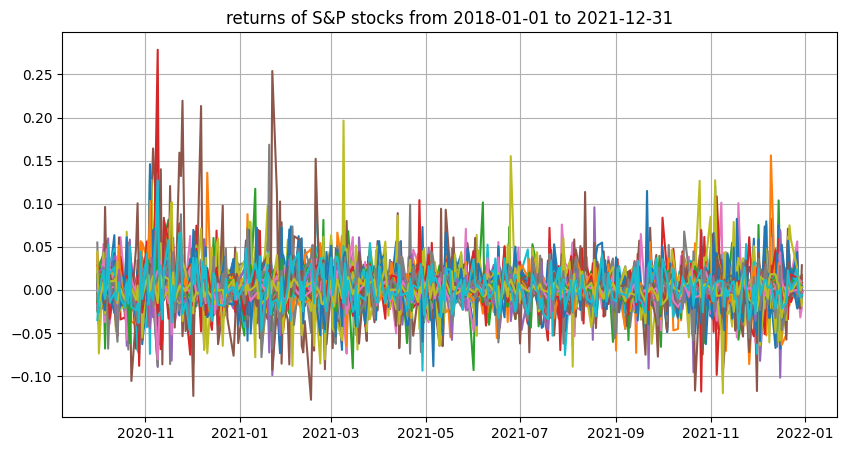

In [439]:
plt.figure(figsize=(10,5))
plt.plot(all_returns)
plt.title(f'returns of S&P stocks from {start.strftime("%Y-%m-%d")} to {end.strftime("%Y-%m-%d")}')
plt.grid()
plt.show()

In [440]:
all_vars=np.diag(all_cov)
all_stds=np.sqrt(all_vars)

/tmp/ipython-input-1305057941.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(txt,(all_stds[i],all_mu[i]))


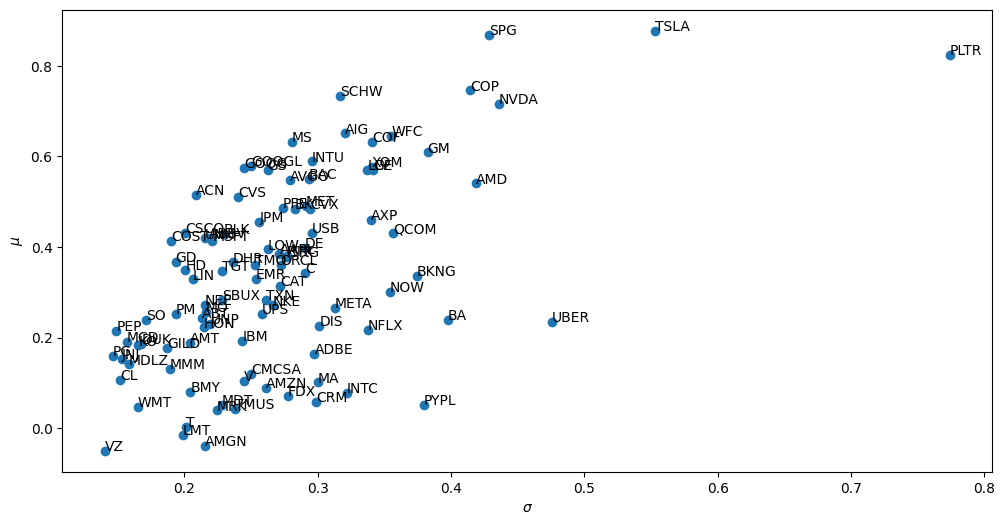

In [441]:
fig,ax=plt.subplots(figsize=(12,6))
ax.scatter(all_stds,all_mu)
for i,txt in enumerate(valid):
    ax.annotate(txt,(all_stds[i],all_mu[i]))

plt.xlabel(r"$\sigma$", fontsize=10)
plt.ylabel(r"$\mu$", fontsize=10)
plt.show()

In [442]:
w_min_all_training=optimalportfolio(all_cov_training)
w_maxsharpe_all_training=optimalportfolio(all_cov_training, all_mu_training, flag=2,shortselling=True)
opt_naive_all_training=ptf_stats(np.ones(len(valid))/len(valid),all_mu_training,all_cov_training,rf)
opt_min_all_training=ptf_stats(w_min_all_training,all_mu_training,all_cov_training,rf)
opt_sharpe_all_training=ptf_stats(w_maxsharpe_all_training,all_mu_training,all_cov_training,rf)

In [443]:
opt_stats_all=pd.DataFrame([opt_naive_all_training,opt_min_all_training,opt_sharpe_all_training],
                            columns=['Exp ret','Var','SR'],
                            index=['Naive','Minvar','Maxsharpe'])

<Axes: >

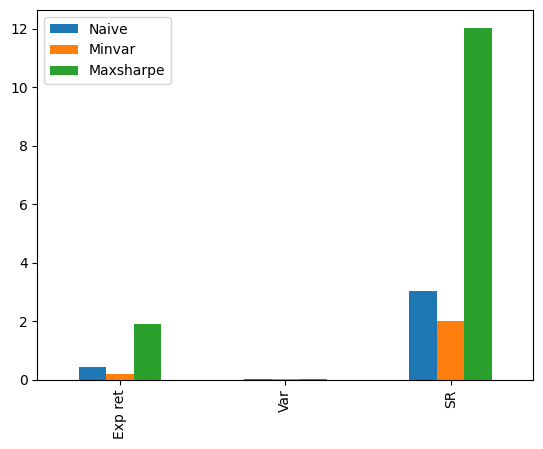

In [444]:
opt_stats_all.T.plot(kind='bar')

In [445]:
corr_training_all=cov_corr(all_cov_training)
corr_training_all

Ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UBER,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,1.000000,0.137278,0.307850,0.390653,0.646555,-0.021392,0.559568,0.309001,0.411602,0.712491,...,0.226368,0.176243,0.166690,0.303897,-0.054370,0.333823,-0.008820,0.005139,0.309763,-0.003650
ABBV,0.137278,1.000000,0.266416,0.281340,0.230778,0.246108,0.105908,0.393342,0.127622,0.114675,...,0.320326,0.427776,0.283575,0.209332,0.208346,0.350488,0.303335,0.267239,0.170121,0.341722
ABT,0.307850,0.266416,1.000000,0.282146,0.385190,-0.092272,0.244758,0.254056,0.285542,0.267112,...,0.146282,0.239708,0.133951,0.130042,-0.058552,0.140714,0.078783,-0.090981,0.202931,-0.091263
ACN,0.390653,0.281340,0.282146,1.000000,0.495536,0.387460,0.258884,0.330393,0.457560,0.340367,...,0.257112,0.357060,0.541249,0.398846,0.298427,0.624202,0.271517,0.308769,0.374588,0.250053
ADBE,0.646555,0.230778,0.385190,0.495536,1.000000,-0.188726,0.607144,0.274220,0.541760,0.760048,...,0.322757,0.269115,0.197454,0.319668,-0.219001,0.390208,-0.096430,-0.127938,0.285062,-0.158122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V,0.333823,0.350488,0.140714,0.624202,0.390208,0.427913,0.265275,0.275912,0.300123,0.319295,...,0.308997,0.372718,0.492639,0.290233,0.399985,1.000000,0.297635,0.326784,0.188752,0.336115
VZ,-0.008820,0.303335,0.078783,0.271517,-0.096430,0.424599,-0.115875,0.303595,0.056875,-0.060035,...,0.049514,0.324702,0.317013,0.196805,0.463881,0.297635,1.000000,0.434187,0.278122,0.319998
WFC,0.005139,0.267239,-0.090981,0.308769,-0.127938,0.713186,-0.037557,0.101586,-0.115422,-0.097408,...,0.255822,0.208831,0.409683,0.188100,0.793961,0.326784,0.434187,1.000000,0.141015,0.635066


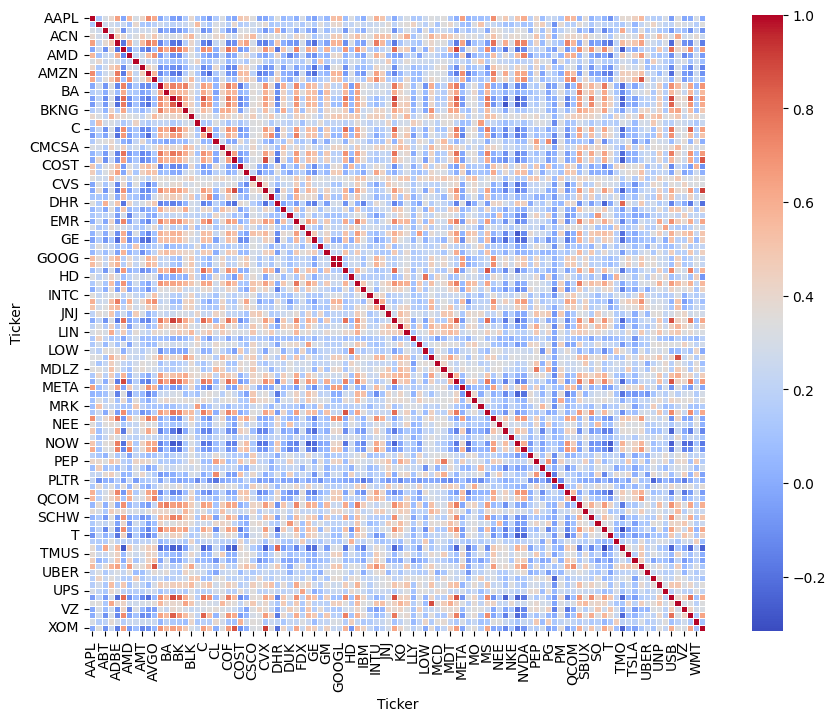

In [446]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_training_all,
            cmap='coolwarm',
            linewidths=0.5,
            square=True)
plt.show()

In [447]:
corr_pairs=corr_training_all[corr_training_all > 0]
for i in range(len(corr_pairs.index)):
  for j in range(i+1,len(corr_pairs.columns)):
    if corr_pairs.iloc[i,j]>0.7:
      ticker1=corr_pairs.index[i]
      ticker2=corr_pairs.columns[j]
      corr_value=corr_pairs.iloc[i,j]
      print(f"{ticker1} and {ticker2}: {corr_value:.4f}")

AAPL and AMZN: 0.7125
AAPL and MSFT: 0.7051
ADBE and AMZN: 0.7600
ADBE and INTU: 0.7548
ADBE and MSFT: 0.7884
ADBE and NOW: 0.7528
ADBE and NVDA: 0.7353
ADBE and PYPL: 0.7372
AIG and AXP: 0.7381
AIG and BAC: 0.8049
AIG and BK: 0.7623
AIG and C: 0.7120
AIG and COF: 0.7814
AIG and EMR: 0.7295
AIG and JPM: 0.7942
AIG and MET: 0.8910
AIG and MS: 0.7112
AIG and RTX: 0.7017
AIG and SPG: 0.7079
AIG and USB: 0.7982
AIG and WFC: 0.7132
AMD and NVDA: 0.7391
AMZN and META: 0.7041
AMZN and MSFT: 0.7562
AVGO and INTU: 0.7023
AVGO and NVDA: 0.7037
AVGO and QCOM: 0.7526
AVGO and TXN: 0.8524
AXP and BAC: 0.7462
AXP and BKNG: 0.7465
AXP and COF: 0.7656
AXP and CVX: 0.7006
AXP and EMR: 0.7179
AXP and JPM: 0.7679
AXP and MET: 0.7568
AXP and RTX: 0.7016
AXP and SPG: 0.7610
AXP and USB: 0.7064
BA and RTX: 0.7580
BAC and BK: 0.8428
BAC and C: 0.8495
BAC and COF: 0.7743
BAC and GS: 0.7702
BAC and JPM: 0.9110
BAC and MET: 0.8341
BAC and MS: 0.7734
BAC and SCHW: 0.7472
BAC and USB: 0.8915
BAC and WFC: 0.8360
B

In [448]:
lower_triangular=corr_training_all.where(np.tril(np.ones(corr_training_all.shape)).astype(bool)).stack()

Summary statistics of correlations:
count    5050.000000
mean        0.267317
std         0.226273
min        -0.315125
25%         0.122284
50%         0.251885
75%         0.387300
max         1.000000
dtype: float64


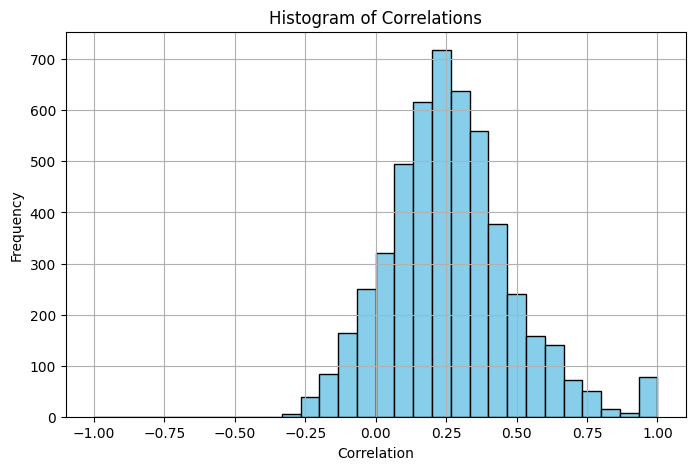

In [449]:

print("Summary statistics of correlations:")
print(lower_triangular.describe())

plt.figure(figsize=(8, 5))
plt.hist(lower_triangular, bins=30, range=(-1, 1), color='skyblue', edgecolor='black')
plt.title('Histogram of Correlations')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [450]:
std_all_training=np.sqrt(np.diag(all_cov_training))
corr2cov(corr_training_all,std_all_training)

Ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UBER,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,0.089822,0.009620,0.021946,0.024731,0.055791,-0.002173,0.065979,0.021282,0.027034,0.058003,...,0.033791,0.012158,0.011974,0.025049,-0.005246,0.023690,-0.000392,0.000579,0.016432,-0.000419
ABBV,0.009620,0.054673,0.014817,0.013895,0.015536,0.019502,0.009743,0.021136,0.006539,0.007283,...,0.037305,0.023023,0.015892,0.013461,0.015684,0.019405,0.010525,0.023494,0.007041,0.030617
ABT,0.021946,0.014817,0.056576,0.014176,0.026379,-0.007438,0.022904,0.013887,0.014884,0.017258,...,0.017330,0.013124,0.007636,0.008507,-0.004484,0.007925,0.002781,-0.008136,0.008543,-0.008318
ACN,0.024731,0.013895,0.014176,0.044617,0.030137,0.027736,0.021514,0.016038,0.021180,0.019529,...,0.027049,0.017360,0.027402,0.023170,0.020294,0.031220,0.008511,0.024522,0.014005,0.020239
ADBE,0.055791,0.015536,0.026379,0.030137,0.082897,-0.018415,0.068773,0.018144,0.034183,0.059441,...,0.046284,0.017834,0.013626,0.025313,-0.020300,0.026603,-0.004120,-0.013850,0.014527,-0.017445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V,0.023690,0.019405,0.007925,0.031220,0.026603,0.034339,0.024713,0.015014,0.015574,0.020537,...,0.036442,0.020314,0.027959,0.018901,0.030493,0.056070,0.010458,0.029093,0.007911,0.030497
VZ,-0.000392,0.010525,0.002781,0.008511,-0.004120,0.021353,-0.006765,0.010353,0.001850,-0.002420,...,0.003660,0.011091,0.011275,0.008032,0.022162,0.010458,0.022021,0.024225,0.007305,0.018196
WFC,0.000579,0.023494,-0.008136,0.024522,-0.013850,0.090874,-0.005555,0.008778,-0.009510,-0.009948,...,0.047907,0.018072,0.036919,0.019450,0.096107,0.029093,0.024225,0.141364,0.009384,0.091495


In [451]:
N = corr_training_all.shape[0]
corr_sum = (np.sum(np.sum(corr_training_all))-N)/2
n_corrs = N*(N-1)/2
average_corr = corr_sum/n_corrs

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [452]:
C_rhobar=average_corr*np.ones(shape=(N,N))
for i in range(int(N)):
  C_rhobar[i,i]=1

In [453]:
S_rhobar=corr2cov(C_rhobar,std_all_training)

In [454]:
cov_training_shrunk=shrinkage(all_prices_traninig)
cov_training_shrunk

Ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UBER,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,0.089822,0.013658,0.019973,0.020358,0.038791,0.011737,0.047877,0.019337,0.021809,0.039280,...,0.035742,0.014789,0.015056,0.022931,0.009559,0.020805,0.005419,0.014517,0.014914,0.014290
ABBV,0.013658,0.054673,0.014430,0.013183,0.016268,0.019756,0.016486,0.017352,0.009739,0.011661,...,0.033356,0.018306,0.015022,0.014850,0.017347,0.016693,0.009643,0.022847,0.008746,0.026621
ABT,0.019973,0.014430,0.056576,0.013431,0.021836,0.006459,0.023267,0.013845,0.014023,0.016786,...,0.023622,0.013474,0.011016,0.012513,0.007427,0.011074,0.005847,0.007223,0.009587,0.007349
ACN,0.020358,0.013183,0.013431,0.044617,0.022747,0.022906,0.021249,0.014148,0.016435,0.017008,...,0.026808,0.014818,0.020093,0.018920,0.018733,0.021925,0.008213,0.022288,0.011723,0.020339
ADBE,0.038791,0.016268,0.021836,0.022747,0.082897,0.003112,0.048688,0.017426,0.025058,0.039595,...,0.041248,0.017284,0.015526,0.022654,0.001553,0.021909,0.003334,0.006743,0.013698,0.005207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V,0.020805,0.016693,0.011074,0.021925,0.021909,0.027301,0.024118,0.014378,0.014339,0.018389,...,0.033112,0.017038,0.021145,0.017673,0.024871,0.056070,0.009666,0.025787,0.009247,0.026705
VZ,0.005419,0.009643,0.005847,0.008213,0.003334,0.017026,0.003989,0.009482,0.005031,0.003879,...,0.011162,0.009858,0.010128,0.009169,0.017113,0.009666,0.022021,0.019157,0.006969,0.016277
WFC,0.014517,0.022847,0.007223,0.022288,0.006743,0.061525,0.015898,0.015298,0.005648,0.007920,...,0.047597,0.019963,0.029837,0.022781,0.063337,0.025787,0.019157,0.141364,0.013094,0.063938


In [455]:
w_minVar_training_shrunk = optimalportfolio(cov_training_shrunk)
w_MaxSharpe_training_shrunk = optimalportfolio(cov_training_shrunk, all_mu_training, 2, True)

w_minVar_shrunk_statsOOS = ptf_stats(w_minVar_training_shrunk, all_mu_testing, all_cov_testing, rf_testing)
w_MaxSharpe_shrunk_statsOSS = ptf_stats(w_MaxSharpe_training_shrunk, all_mu_testing, all_cov_testing, rf_testing)

stats_OOS = pd.DataFrame([opt_naive_all_training, opt_min_all_training, opt_sharpe_all_training, w_minVar_shrunk_statsOOS, w_MaxSharpe_shrunk_statsOSS],\
                    columns = ['Exp Return', 'Var', 'SR'],
                    index = ['Naive','Min Var','Max Sharpe', 'Min Var - shrunk', 'Max Sharpe - shrunk'])

stats_OOS.T

,Naive,Min Var,Max Sharpe,Min Var - shrunk,Max Sharpe - shrunk
Exp Return,0.444457,0.202201,1.908786,0.134433,1.689811
Var,0.020644,0.009171,0.024818,0.008718,0.781252
SR,3.018001,1.998287,12.047746,1.435299,1.911325


<Axes: >

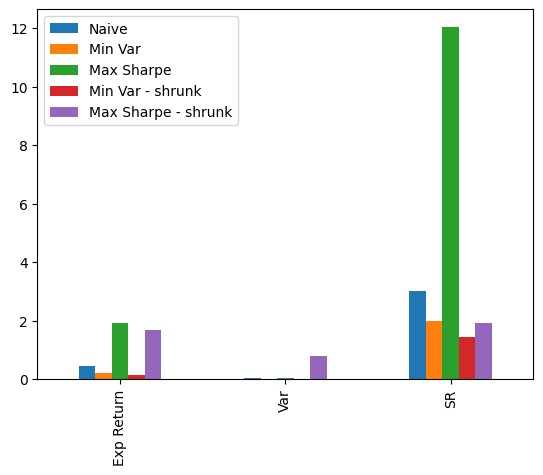

In [456]:
(stats_OOS.T).plot(kind='bar')

In [457]:
# Quick snippet to visualize the frontier
def plot_frontier(mu, cov, rf):
    # Generate random portfolios
    n_pts = 50000
    results = np.zeros((3, n_pts))  # sigma, mu, sharpe
    for i in range(n_pts):
      w = np.random.random(len(mu))
      w /= np.sum(w)
      r, v, sr = ptf_stats(w, mu, cov, rf)
      results[0,i] = np.sqrt(v)
      results[1,i] = r
      results[2,i] = sr
    # Move scatter plot outside the loop
    plt.scatter(
        results[0,:],
        results[1,:],
        c=results[2,:],
        cmap='viridis',
        s=10,
        alpha=0.4
    )
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel(r"$\sigma_p$")
    plt.ylabel(r"$\mu_p$")
    plt.grid(True)
    plt.show()


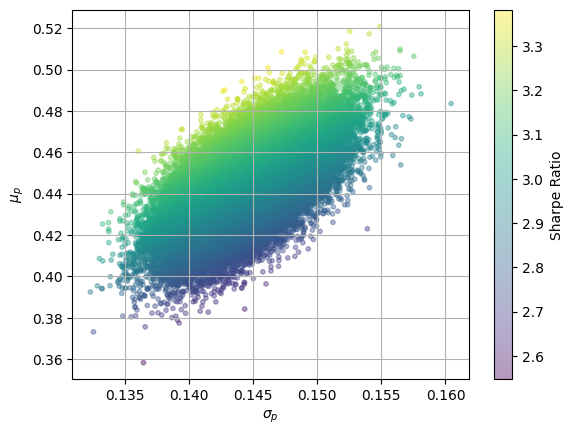

In [458]:
plot_frontier(all_mu_training, all_cov_training, rf)